# Viewing NEXRAD Level II Data
---

## Overview
   
Within this notebook, we will cover:

1. How to access NEXRAD data from AWS
1. How to read this data into Py-ART
1. How to customize your plots and maps

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Required | Projections and Features |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Required | Basic plotting |
| [Py-ART Basics](../foundations/pyart-basics) | Required | IO/Visualization |

- **Time to learn**: 45 minutes
---

## Imports

In [14]:
import pyart
import fsspec
from metpy.plots import USCOUNTIES
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from datetime import datetime as dt
warnings.filterwarnings("ignore")

## How to Access NEXRAD Data from Amazon Web Services (AWS)

Let’s start first with NEXRAD Level 2 data, which is ground-based radar data collected by the National Oceanic and Atmospheric Administration (NOAA), as a part of the National Weather Service (NWS) observing network.

### Level 2 Data
Level 2 data includes all of the fields in a single file - for example, a file may include:
- Reflectivity
- Velocity

### Search for Radar Data

We will access data from the [noaa-nexrad-level2 bucket](https://noaa-nexrad-level2.s3.amazonaws.com/index.html), with the data organized as:

```
s3://noaa-nexrad-level2/year/month/date/radarsite/{radarsite}{year}{month}{date}_{hour}{minute}{second}_V06
```

We can use [fsspec](https://filesystem-spec.readthedocs.io/en/latest/), a tool to work with filesystems in Python, to search through the bucket to find our files!

We start first by setting up our [AWS S3 filesystem](https://aws.amazon.com/s3/)

In [15]:
fs = fsspec.filesystem("s3", anon=True)

Once we set up our filesystem, we can list files from the site and date/time of our choice.

Select the date

In [16]:
datTime = dt(2013,5,20,20)
year = dt.strftime(datTime,format="%Y")
month = dt.strftime(datTime,format="%m")
day = dt.strftime(datTime,format="%d")
hour = dt.strftime(datTime,format="%H")

Specify the radar site

In [17]:
site = 'KTLX'

Specify latitude and longitude bounds for the resulting maps.

In [18]:
lonW = -99
lonE = -96
latS = 33
latN = 36

Construct the URL pointing to the radar file directory

In [19]:
url = f's3://noaa-nexrad-level2/{year}/{month}/{day}/{site}/{site}{year}{month}{day}_{hour}*V06'

In [20]:
url

's3://noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_20*V06'

In [21]:
files = sorted(fs.glob(url))
files

[]

We now have a list of files we can read in! 

## Read the Data into PyART

When reading into PyART, we can use the `pyart.io.read_nexrad_archive` or `pyart.io.read` module to read in our data.

Read in the first radar file in the group.

In [22]:
radar = pyart.io.read_nexrad_archive(f's3://{files[0]}')

IndexError: list index out of range

Notice how for the **NEXRAD Level 2** data, we have several fields available

In [ ]:
list(radar.fields)

### Plot a quick-look of the dataset
Let's get a quick look of the reflectivity and velocity fields

In [ ]:
display = pyart.graph.RadarMapDisplay(radar)

What options does plot_ppi_map give us?

In [10]:
display.plot_ppi_map?

Object `display.plot_ppi_map` not found.


The default resolution for the cartographic features is the coarsest (110m). Let's crank it up to the finest resolution ('10m').

In [11]:
res = '10m'

In [12]:
display.plot_ppi_map('reflectivity',
                     sweep=3,
                     vmin=-20,
                     vmax=80,
                     projection=ccrs.PlateCarree(),
                     resolution=res
                    )

AttributeError: 'function' object has no attribute 'plot_ppi_map'

In [13]:
display.plot_ppi_map('velocity',
                     sweep=3,
                     projection=ccrs.PlateCarree(),
                     resolution=res
                    )

AttributeError: 'function' object has no attribute 'plot_ppi_map'

## Create a single figure of reflectivity, zoomed into the main storm. Add counties and other enhancements.

In [73]:
lonW = -99
lonE = -96
latS = 33
latN = 36

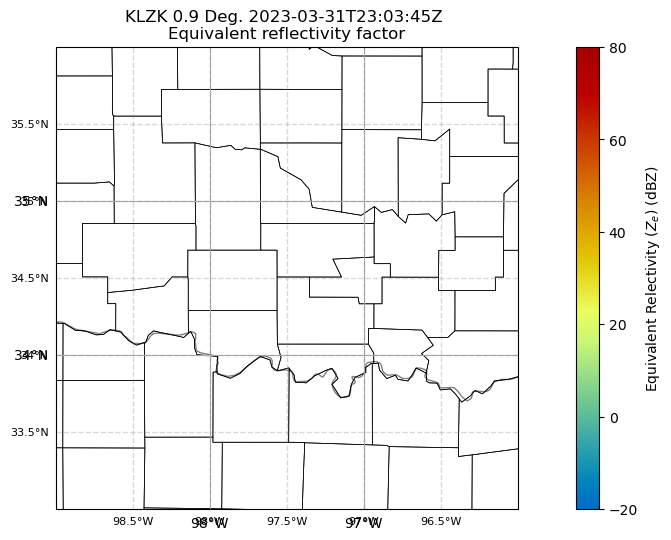

In [74]:
# Create our figure
fig = plt.figure(figsize=[15, 6])

# Setup our first axis with reflectivity
ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
ref_map = display.plot_ppi_map('reflectivity',sweep=3, vmin=-20, vmax=80, ax=ax1, colorbar_label='Equivalent Relectivity ($Z_{e}$) (dBZ)', resolution=res)

ax1.set_extent ([lonW, lonE, latS, latN])

# Add gridlines
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')

# Make sure labels are only plotted on the left and bottom
gl.xlabels_top = False
gl.ylabels_right = False

# Specify the fontsize of our gridline labels
gl.xlabel_style = {'fontsize':8}
gl.ylabel_style = {'fontsize':8}

# Add counties
ax1.add_feature(USCOUNTIES, linewidth=0.5);


Next, let's create a function that does the same as the previous cell, so we can loop over all the radar files of the specified hour.

In [75]:
def plot_radar_refl (idx, site):
    radar = pyart.io.read_nexrad_archive(f's3://{files[idx]}')    
    # Create our figure
    fig = plt.figure(figsize=[15, 6])

    # Set up our axes
    ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
    display = pyart.graph.RadarMapDisplay(radar)
    ref_map = display.plot_ppi_map('reflectivity',sweep=3, vmin=-20, vmax=80, ax=ax1, colorbar_label='Equivalent Relectivity ($Z_{e}$) (dBZ)', resolution=res)

    ax1.set_extent ([lonW, lonE, latS, latN])

# Add gridlines
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')

# Make sure labels are only plotted on the left and bottom
    gl.xlabels_top = False
    gl.ylabels_right = False

# Specify the fontsize of our gridline labels
    gl.xlabel_style = {'fontsize':8}
    gl.ylabel_style = {'fontsize':8}

# Add counties
    ax1.add_feature(USCOUNTIES, linewidth=0.5)

# Save the figure.
    fNum = str(idx).zfill(2)
    figTitle = f'{site}_refl_{fNum}.png'
    fig.savefig(figTitle)

Loop over the files. Save each image.

In [76]:
for n, name in enumerate(files):
    print (n, name, site)
    plot_radar_refl(n, site)    

---
## Summary
Within this example, we walked through how to use PyART to read in and plot NEXRAD Level 2 data for a location and hour of your choice.

### Things to try
The above example is for reflectivity. Try additional radar products, such as velocity; also try different sweeps.

### What's next?
We will develop code to animate the sequence.